<a href="https://colab.research.google.com/github/mpjuarez/trabajo_final_sistemasR/blob/main/SR_trabajoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** 1. Instalar e importar librerias**

In [48]:
!pip install pandas numpy scikit-surprise
!pip install scipy

**importación de librerias**

In [63]:
import pandas as pd
import numpy as np
import os
from surprise import Dataset, Reader
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from scipy.sparse import csr_matrix #Para crear la matriz usuario-pelicula
from sklearn.metrics import precision_score, recall_score

**Cargar el conjunto de datos y Presentar características**

In [64]:
#se clona el repositorio de github
!rm -rf trabajo_final_sistemasR
!git clone https://github.com/mpjuarez/trabajo_final_sistemasR.git


Cloning into 'trabajo_final_sistemasR'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
Receiving objects: 100% (29/29), 51.90 KiB | 759.00 KiB/s, done.
Resolving deltas: 100% (9/9), done.
remote: Total 29 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)


In [65]:
#Cargar el dataset de rating, geoplaces y presentar la cantidad de columnas y filas, así tambien los tipos de datos
rating = pd.read_csv('trabajo_final_sistemasR/rating_final.csv')
geoplaces = pd.read_csv('trabajo_final_sistemasR/geoplaces2.csv', encoding='latin-1')
print(rating.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161 entries, 0 to 1160
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userID          1161 non-null   object
 1   placeID         1161 non-null   int64 
 2   rating          1161 non-null   int64 
 3   food_rating     1161 non-null   int64 
 4   service_rating  1161 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 45.5+ KB
None


In [66]:
print(geoplaces.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   placeID         130 non-null    int64  
 1   latitude        130 non-null    float64
 2   longitude       130 non-null    float64
 3   the_geom_meter  130 non-null    object 
 4   name            130 non-null    object 
 5   address         130 non-null    object 
 6   city            130 non-null    object 
 7   state           130 non-null    object 
 8   country         130 non-null    object 
 9   fax             130 non-null    object 
 10  zip             130 non-null    object 
 11  alcohol         130 non-null    object 
 12  smoking_area    130 non-null    object 
 13  dress_code      130 non-null    object 
 14  accessibility   130 non-null    object 
 15  price           130 non-null    object 
 16  url             130 non-null    object 
 17  Rambience       130 non-null    obj

In [67]:

# Estadísticas iniciales del archivo `rating_final.csv`
num_users = rating['userID'].nunique()
num_places = rating['placeID'].nunique()
total_ratings = len(rating)
sparsity = 1 - (total_ratings / (num_users * num_places))

# Resumen de estadísticas
stats = {
    "Número de usuarios únicos": num_users,
    "Número de restaurantes únicos": num_places,
    "Cantidad total de calificaciones": total_ratings,
    "Porcentaje de escasez": f"{sparsity:.2%}"
}

stats

{'Número de usuarios únicos': 138,
 'Número de restaurantes únicos': 130,
 'Cantidad total de calificaciones': 1161,
 'Porcentaje de escasez': '93.53%'}

In [68]:
# Muestra las primeras 10 filas de rating
print("Primeras 10 filas de rating:")
display(rating.head(10))

# Muestra las primeras 10 filas de geoplaces
print("\nPrimeras 10 filas de geoplaces:")
display(geoplaces.head(10))

Primeras 10 filas de rating:


,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2
5,U1068,132740,0,0,0
6,U1068,132663,1,1,1
7,U1068,132732,0,0,0
8,U1068,132630,1,1,1
9,U1067,132584,2,2,2



Primeras 10 filas de geoplaces:


,placeID,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,...,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services
0,134999,18.915421,-99.184871,0101000020957F000088568DE356715AC138C0A525FC46...,Kiku Cuernavaca,Revolucion,Cuernavaca,Morelos,Mexico,?,...,No_Alcohol_Served,none,informal,no_accessibility,medium,kikucuernavaca.com.mx,familiar,f,closed,none
1,132825,22.147392,-100.983092,0101000020957F00001AD016568C4858C1243261274BA5...,puesto de tacos,esquina santos degollado y leon guzman,s.l.p.,s.l.p.,mexico,?,...,No_Alcohol_Served,none,informal,completely,low,?,familiar,f,open,none
2,135106,22.149709,-100.976093,0101000020957F0000649D6F21634858C119AE9BF528A3...,El Rincón de San Francisco,Universidad 169,San Luis Potosi,San Luis Potosi,Mexico,?,...,Wine-Beer,only at bar,informal,partially,medium,?,familiar,f,open,none
3,132667,23.752697,-99.163359,0101000020957F00005D67BCDDED8157C1222A2DC8D84D...,little pizza Emilio Portes Gil,calle emilio portes gil,victoria,tamaulipas,?,?,...,No_Alcohol_Served,none,informal,completely,low,?,familiar,t,closed,none
4,132613,23.752903,-99.165076,0101000020957F00008EBA2D06DC8157C194E03B7B504E...,carnitas_mata,lic. Emilio portes gil,victoria,Tamaulipas,Mexico,?,...,No_Alcohol_Served,permitted,informal,completely,medium,?,familiar,t,closed,none
5,135040,22.135617,-100.969709,0101000020957F00001B552189B84A58C15A2AAEFD2CA2...,Restaurant los Compadres,Camino a Simon Diaz 155 Centro,San Luis Potosi,SLP,Mexico,?,...,Wine-Beer,none,informal,no_accessibility,high,?,familiar,f,closed,none
6,132732,23.754357,-99.171288,0101000020957F00008A20E615808157C16272FECBF84F...,Taqueria EL amigo,Calle Mezquite Fracc Framboyanes,Cd Victoria,Tamaulipas,Mexico,?,...,No_Alcohol_Served,none,casual,completely,low,?,familiar,f,open,none
7,132875,22.149901,-100.993779,0101000020957F00008A2A0747DE4758C11EB31D2A31A8...,shi ro ie,?,?,?,?,?,...,Wine-Beer,section,informal,no_accessibility,high,?,familiar,t,open,Internet
8,132609,23.760268,-99.165865,0101000020957F0000A478418BBA8057C133851EB22C4E...,Pollo_Frito_Buenos_Aires,tampico,victoria,Tamaulipas,Mexico,?,...,No_Alcohol_Served,not permitted,informal,completely,low,?,quiet,t,closed,none
9,135082,22.151448,-100.915099,0101000020957F0000A29FAF95CD4958C1FEEEBB73A991...,la Estrella de Dimas,Villa de Pozos 192 Villa de Pozos,San Luis Potosi,SLP,Mexico,?,...,No_Alcohol_Served,none,informal,no_accessibility,medium,?,familiar,f,closed,none


**Limpieza del dataset rating_final**

Validar valores nulos en el dataset rating_final.csv

In [69]:
print("\n valores nulos en el rating_final.csv:")
print(rating.isnull().sum())


 valores nulos en el rating_final.csv:
userID            0
placeID           0
rating            0
food_rating       0
service_rating    0
dtype: int64


**Limpieza del dataset geoplaces2**

In [70]:
# Reemplazar caracteres '?' por NaN
geoplaces_cleaned = geoplaces.replace('?', pd.NA)

# Identificar y eliminar columnas innecesarias
columns_to_drop = ['fax', 'url', 'the_geom_meter']  # Ajustar según necesidad
geoplaces_cleaned = geoplaces_cleaned.drop(columns=columns_to_drop, errors='ignore')

# Verificar valores nulos después de la limpieza
geoplaces_missing_after = geoplaces_cleaned.isnull().sum()

# Mostrar resultados
print("Valores nulos después de la limpieza:")
print(geoplaces_missing_after)
print("\nPrimeras filas del dataset limpio:")
print(geoplaces_cleaned.head())

Valores nulos después de la limpieza:
placeID            0
latitude           0
longitude          0
name               0
address           27
city              18
state             18
country           28
zip               74
alcohol            0
smoking_area       0
dress_code         0
accessibility      0
price              0
Rambience          0
franchise          0
area               0
other_services     0
dtype: int64

Primeras filas del dataset limpio:
   placeID   latitude   longitude                            name  \
0   134999  18.915421  -99.184871                 Kiku Cuernavaca   
1   132825  22.147392 -100.983092                 puesto de tacos   
2   135106  22.149709 -100.976093      El Rincón de San Francisco   
3   132667  23.752697  -99.163359  little pizza Emilio Portes Gil   
4   132613  23.752903  -99.165076                   carnitas_mata   

                                  address             city            state  \
0                              Revolucion

Eliminar duplicados en el dataset rating_final.csv

In [71]:
rating_df = pd.read_csv('trabajo_final_sistemasR/rating_final.csv')
if rating_df.duplicated().sum()>0:
    print('\nEliminar filas duplicada en el dataset rating_final.csv')
    rating_df.drop_duplicates(inplace=True)

In [72]:
print('\nValores nulos en el dataset rating_final.csv')
print(rating_df.head())


Valores nulos en el dataset rating_final.csv
  userID  placeID  rating  food_rating  service_rating
0  U1077   135085       2            2               2
1  U1077   135038       2            2               1
2  U1077   132825       2            2               2
3  U1077   135060       1            2               2
4  U1068   135104       1            1               2


Estadísticas descriptivas de las calificaciones:
            rating  food_rating  service_rating
count  1161.000000  1161.000000     1161.000000
mean      1.199828     1.215332        1.090439
std       0.773282     0.792294        0.790844
min       0.000000     0.000000        0.000000
25%       1.000000     1.000000        0.000000
50%       1.000000     1.000000        1.000000
75%       2.000000     2.000000        2.000000
max       2.000000     2.000000        2.000000


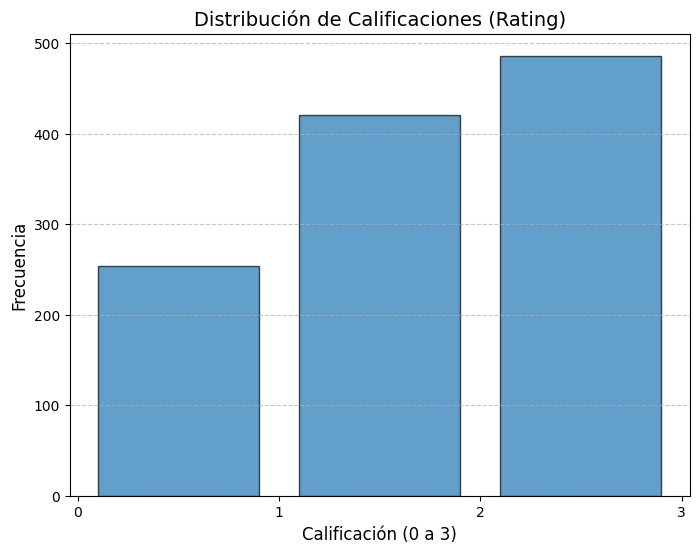

In [82]:
import matplotlib.pyplot as plt

print("Estadísticas descriptivas de las calificaciones:")
print(ratings_stats)

# Crear el histograma para la columna 'rating'
plt.figure(figsize=(8, 6))
plt.hist(rating_df['rating'], bins=[0, 1, 2, 3], edgecolor='black', alpha=0.7, rwidth=0.8)
plt.title("Distribución de Calificaciones (Rating)", fontsize=14)
plt.xlabel("Calificación (0 a 3)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.xticks([0, 1, 2, 3])  # Asegurar que aparezcan todas las etiquetas de calificación
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()